In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import re
import nltk
import jieba
import spacy
import string
import emoji
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import StepLR
from IPython.display import FileLink
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
if torch.cuda.is_available():
    print("CUDA is available. You have GPU support.")
else:
    print("CUDA is not available. You do not have GPU support.")

CUDA is available. You have GPU support.


# Load Pikle file for Preprocessed Dataframe

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_valset_mBERT.pkl
/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_trainset_mBERT.pkl
/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_testset_mBERT.pkl
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/MangolianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/IrishTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/HindiTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/PersianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/UrduTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/GeorgianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbed

In [4]:
preprocessed_trainset = pd.read_pickle('/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_trainset_mBERT.pkl')
preprocessed_valset = pd.read_pickle('/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_valset_mBERT.pkl')
preprocessed_testset = pd.read_pickle('/kaggle/input/preprocessed_mbert/other/without/1/preprocessed_testset_mBERT.pkl')

In [5]:
preprocessed_trainset

,text,label,language,cleaned_text
0,@m__isis ...,0.0,2,
1,"'How ISIS Brainwashed Me', an American Young G...",0.0,2,isi brainwash american young girl speaks
2,Muslim Man Hugs ISIS Militant Armed Wearing Su...,0.0,2,muslim man hug isi militant arm wear suicide v...
3,Le grand absent de l'euro a aura t daesh,0.0,2,le grand absent de leuro aura daesh
4,RT @joej2020usa: Netanyahu: Paris Massacre Sho...,1.0,2,netanyahu paris massacre show radical islam kn...
...,...,...,...,...
51139,USER USER Ritual Puasa tiap tanggal 10 Muharra...,0.0,13,ritual puasa tanggal muharram tradisi yahud ma...
51140,USER USER USER USER USER USER USER USER USER U...,1.0,13,cocok kata sontoloyo bom kampung kasih mati orang
51141,USER USER USER USER USER USER USER USER USER U...,0.0,13,p
51142,"RT USER: Jidatnya Gosong ,gaya Islami tp Menta...",1.0,13,jidat gosong gaya islam mental bajinganpedagan...


In [6]:
preprocessed_valset

,text,label,language,cleaned_text
0,Massive explosion rocked Sadr city east #Baghd...,1.0,2,massive explosion rock sadr city east baghdad ...
1,@user @user @user well didnt pay 1000$ phone 1...,1.0,2,well didnt pay phone st world mongoloid
2,RT @_______Krista: Vous n'avez pas peur de Die...,0.0,2,vous navez pas peur de dieu mais vous avez peu...
3,RT @Nidalgazaui: Dozens of Shiite Hasd-Al-Shab...,1.0,2,dozen shiite hasdalshab leader kill diyala isi...
4,@user see ferocity flames twat. indentificatio...,0.0,2,see ferocity flame twat indentification inform...
...,...,...,...,...
21915,USER Gapapa sipit juga cantik aku mah \xf0\x9f...,0.0,13,gapapa sipit cantik mah
21916,Koalisi tapi pakai hati. Cuci tangan sambil be...,0.0,13,koalisi paka hati cuci tangan gandeng topeng r...
21917,USER ke jamban ?',0.0,13,jamban
21918,USER Ngga ada kucing yang kesurupan karena kuc...,1.0,13,kucing surup kucing setan


In [7]:
preprocessed_testset

,text,label,language,cleaned_text
0,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,2,pakistani irgc zeynabiun brigade kill north sy...
1,gronk tide pod commercial retarded,1.0,2,gronk tide pod commercial retard
2,@sfrantzman @pmakela1 what they found in Syria...,0.0,2,find syria lot weapon wwii gun shop isi lot ir...
3,After Pakistani Taliban announcement of their ...,0.0,2,pakistani taliban announcement support isi lin...
4,Good luck getting our attention this week ISIS...,0.0,2,good luck get attention week isi pokemongo
...,...,...,...,...
8115,"Ajarkan Muslim, agama tak ngajarkan membunuh, ...",1.0,13,ajar muslim agama ngajar bunuh paham islam aga...
8116,"RT USER: Mainstream sdh jelas,bhw oposisi meng...",0.0,13,mainstream jelasbhw oposisi esan neger masalah...
8117,"Bismillah,; superiorPRINTING;; Harga; Ecer :LG...",0.0,13,bismil superiorprinting harga ecer lgnpoloskpr...
8118,Nama Lengkap : Iris Jung\n\nNama Asli : Jung A...,0.0,13,nama lengkap iris jungnnnama asli jung an rinn...


# Training mBERT

In [8]:
# Load pre-trained mBERT uncased model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Define hyperparameters
learning_rate = 2e-5
batch_size = 32
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience=3
min_delta=0.001
save_path = 'mBERT_over.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [9]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [10]:
# # Tokenize, pad, and convert your dataset
# texts = list(oversampled['text'])
# labels = list(oversampled['label'])

# input_ids = []
# attention_masks = []

# for text in texts:
#     encoded = tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=128,  # Set your desired sequence length
#         padding='max_length',
#         truncation=True,
#         return_tensors='pt',
#     )


#     input_ids.append(encoded['input_ids'])
#     attention_masks.append(encoded['attention_mask'])

# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

In [11]:
# def textDataset(dataframe, tokenizer, max_length=256):
#     """
#     Preprocess text data for transformer-based models.
#     """
#     texts = list(dataframe['cleaned_text'])
#     labels = list(dataframe['label'])

#     input_ids = []
#     attention_masks = []

#     for text in texts:
#         encoded = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True
#         )
#         input_ids.append(encoded['input_ids'])
#         attention_masks.append(encoded['attention_mask'])

#     # Convert lists to tensors
#     input_ids = torch.cat(input_ids, dim=0)
#     attention_masks = torch.cat(attention_masks, dim=0)
#     labels = torch.tensor(labels)

#     # Create a TensorDataset
#     dataset = TensorDataset(input_ids, attention_masks, labels)
#     return dataset

In [12]:
def textDataset(dataframe, tokenizer, max_length=256):
    """
    Preprocess text data for transformer-based models, ensuring that only valid entries are processed.
    """
    # Filter the DataFrame to remove any rows with NaN values in 'cleaned_text' or 'label'
    dataframe = dataframe.dropna(subset=['cleaned_text', 'label'])

    texts = list(dataframe['cleaned_text'])
    labels = list(dataframe['label'])

    input_ids = []
    attention_masks = []

    # Process each text entry in the DataFrame
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)

    # Create a TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

In [13]:
train_dataset = textDataset(preprocessed_trainset, tokenizer)
val_dataset = textDataset(preprocessed_valset, tokenizer)
test_dataset = textDataset(preprocessed_testset, tokenizer)

In [14]:
# Create DataLoader objects for training, validation, and testing
train_dataloader      = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader       = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

In [16]:
def validate_model(model, epoch, val_loader, device, num_epochs):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Val)'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask=attention_mask, labels = labels)
            logits = outputs.logits

            loss = outputs.loss
            total_loss += loss.item()

            predicted = torch.argmax(logits, dim=1).cpu().numpy()
            labels_numpy = labels.cpu().numpy()  # Convert labels to NumPy array

            total += len(labels_numpy)  # Update total with the batch size
            correct += (predicted == labels_numpy).sum()  

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [17]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, save_path):
#     model.to(device)

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     best_val_loss = float('inf')  # Initialize best validation loss to a large number

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss, total, correct = 0, 0, 0

#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

#             optimizer.zero_grad()

#             # Get the model outputs
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

#             # Extract logits from the model outputs
#             logits = outputs.logits

#             # Calculate loss using the extracted logits
# #             loss = criterion(logits, labels)
#             loss = outputs.loss

#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#             # Predictions for calculating accuracy (assuming binary classification)
#             predicted = torch.argmax(logits, dim=1).cpu().numpy()
#             labels_numpy = labels.cpu().numpy()  # Convert labels to NumPy array

#             total += len(labels_numpy)  # Update total with the batch size
#             correct += (predicted == labels_numpy).sum()  # Correct is incremented by the sum of correct predictions 

#         train_avg_loss = total_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_avg_loss)
#         train_accuracies.append(train_accuracy)

#         # Validate the model
#         val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, criterion, device, num_epochs)
#         val_losses.append(val_avg_loss)
#         val_accuracies.append(val_accuracy)

#         # Save the model if it has the best validation loss so far
#         if val_avg_loss < best_val_loss:
#             best_val_loss = val_avg_loss
#             torch.save(model.state_dict(), save_path)
#             print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')

#         scheduler.step()

#         print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

#     return train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler, device, patience, min_delta, save_path):
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stopping_counter = 0  # Initialize the counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        total_loss, total, correct = 0, 0, 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels_numpy = labels.cpu().numpy()
            total += len(labels_numpy)
            correct += (predicted == labels_numpy).sum()

        train_avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_accuracy)

        val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, device, num_epochs)
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping logic
        if val_avg_loss < best_val_loss - min_delta:
            best_val_loss = val_avg_loss
            torch.save(model.state_dict(), save_path)
            print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')
            early_stopping_counter = 0  # Reset counter
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss for {early_stopping_counter} epochs.")
            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}")
                break

        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [19]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, validation_dataloader, optimizer, num_epochs, scheduler, device, patience, min_delta, save_path='mBERT_normal.pth' )

Epoch 1/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  3.99it/s]


End of Epoch 1, Train Loss: 0.3310, Train Accuracy: 85.27%, Val Loss: 0.2676, Val Accuracy: 88.91%
Model saved: Epoch 1 with Val Loss: 0.2676


Epoch 2/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  3.99it/s]


End of Epoch 2, Train Loss: 0.2270, Train Accuracy: 90.61%, Val Loss: 0.2434, Val Accuracy: 89.79%
Model saved: Epoch 2 with Val Loss: 0.2434


Epoch 3/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  3.99it/s]


End of Epoch 3, Train Loss: 0.1736, Train Accuracy: 92.90%, Val Loss: 0.2408, Val Accuracy: 90.14%
Model saved: Epoch 3 with Val Loss: 0.2408


Epoch 4/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  3.99it/s]


End of Epoch 4, Train Loss: 0.1284, Train Accuracy: 94.82%, Val Loss: 0.2668, Val Accuracy: 90.13%
No improvement in validation loss for 1 epochs.


Epoch 5/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  4.00it/s]


End of Epoch 5, Train Loss: 0.0979, Train Accuracy: 95.91%, Val Loss: 0.3070, Val Accuracy: 89.61%
No improvement in validation loss for 2 epochs.


Epoch 6/10 (Val): 100%|██████████| 685/685 [02:51<00:00,  4.00it/s]

End of Epoch 6, Train Loss: 0.0773, Train Accuracy: 96.73%, Val Loss: 0.3518, Val Accuracy: 90.05%
No improvement in validation loss for 3 epochs.
Stopping early at epoch 6


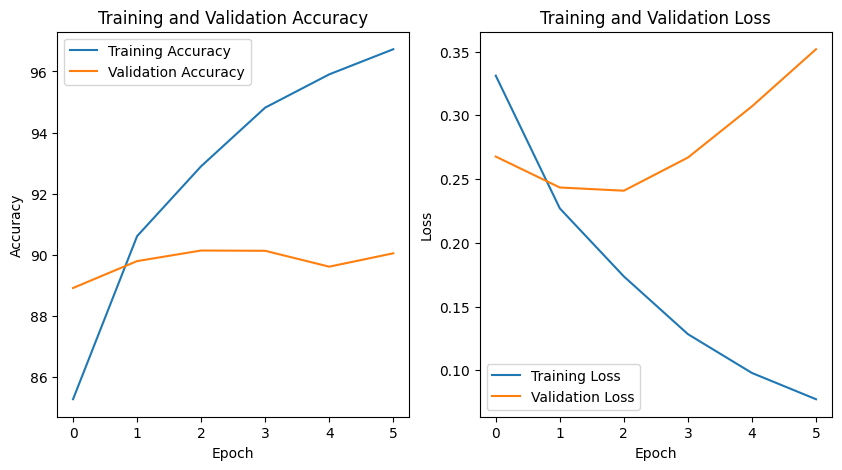

In [20]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# model file link
FileLink(r'mBERT_normal.pth')

/kaggle/working/mBERT_normal.pth

# Evaluation

In [22]:
# def evaluate_model(model, dataloader, device):
#     """
#     Evaluate the given model using the provided dataloader.
#     """
#     # Step 3: Ensure the model is in evaluation mode
#     model.eval()

#     # Send the model to the same device as the data
#     model = model.to(device)

#     # Step 5: Perform inference on the test data
#     test_preds = []
#     test_true = []
#     probs_list = []

#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc='Evaluation'):
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#             outputs = model(input_ids, attention_mask=attention_mask)
#             logits = outputs.logits
#             preds = torch.argmax(logits, dim=1).cpu().numpy()
#             true = labels.cpu().numpy()
#             probs = logits.softmax(dim=1)[:, 1].cpu().numpy()

#             test_preds.extend(preds)
#             test_true.extend(true)
#             probs_list.extend(probs)

#     # Step 6: Calculate evaluation metrics
#     accuracy = accuracy_score(test_true, test_preds)
#     precision = precision_score(test_true, test_preds, average='weighted')
#     recall = recall_score(test_true, test_preds, average='weighted')
#     f1 = f1_score(test_true, test_preds, average='weighted')
#     classification_rep = classification_report(test_true, test_preds)

#     # Print metrics
#     print(f'Accuracy: {accuracy:.4f}')
#     print(f'Precision: {precision:.4f}')
#     print(f'Recall: {recall:.4f}')
#     print(f'F1-Score: {f1:.4f}')
#     print(classification_rep)

#     # Optionally return the metrics as a dictionary
#     return accuracy,precision,recall,f1,classification_rep

In [23]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the given model using the provided dataloader, calculating and plotting
    confusion matrix and ROC curve.
    """
    model.eval()
    model = model.to(device)

    test_preds = []
    test_true = []
    probs_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluation'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true = labels.cpu().numpy()
            probs = logits.softmax(dim=1).cpu().numpy()  # For binary, [:, 1], for multi-class keep probabilities

            test_preds.extend(preds)
            test_true.extend(true)
            probs_list.extend(probs)

    # Metrics calculation
    accuracy = accuracy_score(test_true, test_preds)
    precision = precision_score(test_true, test_preds, average='weighted')
    recall = recall_score(test_true, test_preds, average='weighted')
    f1 = f1_score(test_true, test_preds, average='weighted')
    classification_rep = classification_report(test_true, test_preds)

    # Confusion matrix
    cm = confusion_matrix(test_true, test_preds)

    # ROC Curve - assuming binary classification
    fpr, tpr, thresholds = roc_curve(test_true, [p[1] for p in probs_list], pos_label=1)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(classification_rep)

    return accuracy, precision, recall, f1, classification_rep, cm, fpr, tpr,roc_auc

In [24]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)

model.load_state_dict(torch.load('mBERT_normal.pth'))

accuracy, precision, recall, f1, classification_rep, cm, fpr, tpr,roc_auc = evaluate_model(model, test_dataloader, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|██████████| 254/254 [01:03<00:00,  4.01it/s]


Accuracy: 0.9012
Precision: 0.9019
Recall: 0.9012
F1-Score: 0.9014
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      4593
         1.0       0.87      0.90      0.89      3527

    accuracy                           0.90      8120
   macro avg       0.90      0.90      0.90      8120
weighted avg       0.90      0.90      0.90      8120



## Confusion Matrix

In [25]:
def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plots a confusion matrix using seaborn's heatmap with percentages and TP, TN, FP, FN annotations.
    """
    # Calculate the percentage of each confusion entry
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create annotations that include both count and percentage, and classification (TP, TN, FP, FN)
    annotations = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = conf_matrix[i, j]
            p = conf_matrix_percent[i, j] * 100
            if i == 0 and j == 0:
                label = "TN"
            elif i == 0 and j == 1:
                label = "FP"
            elif i == 1 and j == 0:
                label = "FN"
            elif i == 1 and j == 1:
                label = "TP"
            annotations[i, j] = f"{label}\n{c}\n({p:.1f}%)"

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

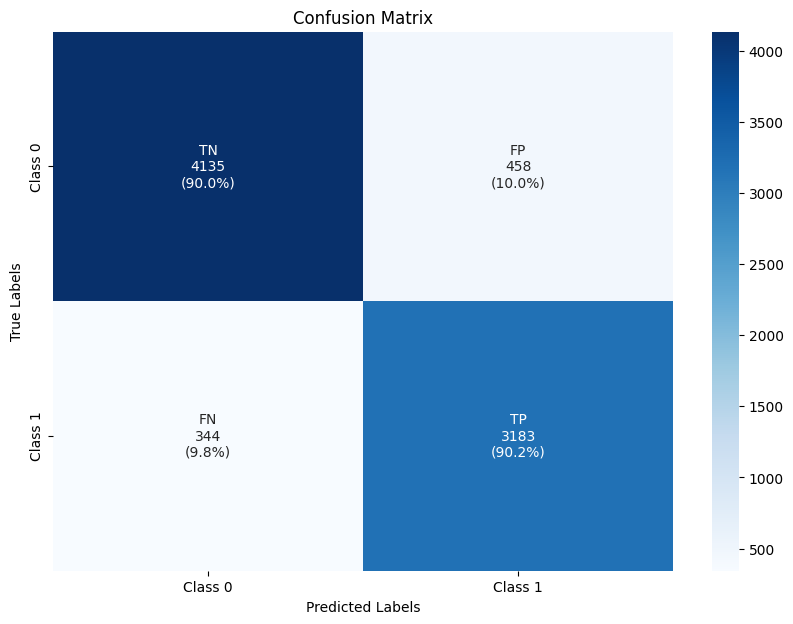

In [26]:
plot_confusion_matrix(cm, class_labels=['Class 0', 'Class 1'])

## ROC

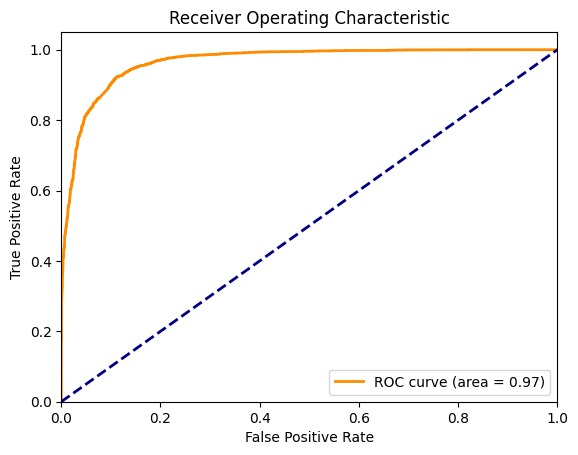

In [27]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
# import pickle
# pickle.dump(model, open('mBERT_model.pkl', 'wb'))